In [2]:
import numpy as np
import pandas as pd

import torch
import torchvision.transforms as T
from PIL import Image
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
import cv2
import matplotlib.pyplot as plt

## 1 Plot segmentation
Take random images from the dataset and try out segmenatation. It can be seen, based on the results, that the segmentation is quite successful (also based on the training metrics from the prior notebook).

In [4]:
def convert_from_image_to_cv2(img: Image) -> np.ndarray:
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

IMG_WIDTH = 188
IMG_HEIGHT = 71
IMG_WIDTH_ORIGINAL = IMG_WIDTH + 15
IMG_HEIGHT_ORIGINAL = IMG_HEIGHT
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)

model = YOLO('yolo6/runs/detect/train/weights/best.pt')


0: 96x224 4 letters, 2 others, 198.5ms
Speed: 15.5ms preprocess, 198.5ms inference, 0.5ms postprocess per image at shape (1, 3, 96, 224)


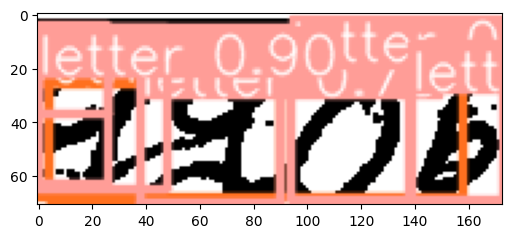

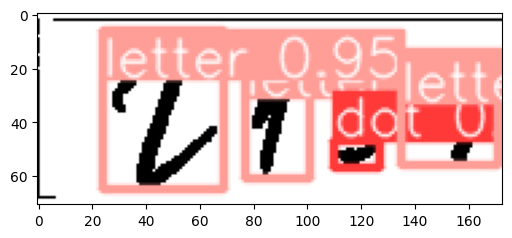

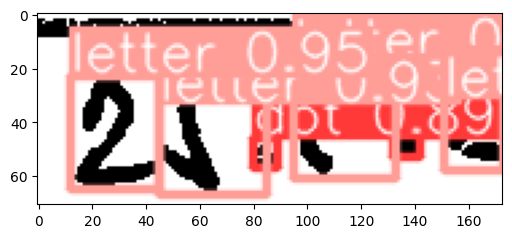

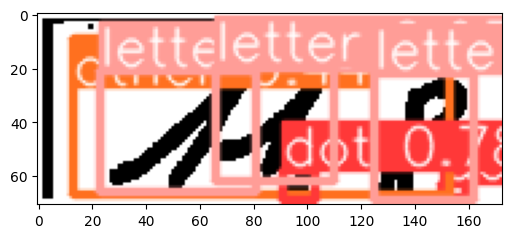

In [9]:
for img_name in range(1008, 1012, 1):
    
    path_img = f'data-dates/{img_name}.png'
    img = Image.open(path_img)

    img = convert_from_image_to_cv2(img)

    # Convert to gray scale, erode and crop the edges
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresholded = cv2.threshold(gray, 215, 255, cv2.THRESH_BINARY)
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    eroded_image = cv2.erode(thresholded, rect_kernel, iterations = 1)
    eroded_image[0:2, :] = 255
    eroded_image[:, 0:2] = 255
    eroded_image[:, -2:] = 255
    eroded_image[-2:, :] = 255
    
    cropped_image = eroded_image[0:IMG_HEIGHT_ORIGINAL, 15:IMG_WIDTH_ORIGINAL - 15]
    img = Image.fromarray(cropped_image)
    
    results = model(Image.open(path_img))
    results=model(img, verbose=False)
    
    plt.figure(figsize=(6,4))
    for r in results:
        im_array = r.plot()
        im_array = im_array[..., ::-1]
        plt.imshow(im_array)

## 2 Create dataset
Create csv dataset in the same format as the MNIST dataset is saved (CSV, 784 columns + label).
- Resize the image using linear interpolation so all the segmented characters will have the shape of 28x28.
- Create training set only containing images. Dots and anomalies are not included (after the consideration in the later notebooks)
- Consider only reasonably big segmented objects (> 40 px of height).

Dataset is created based on the not-preprocessed data. Erosion done there is contraproductive for the digit recognition (as was tested). The rest of the preprocessing is done in the cell below again.

In [13]:
def load_image(path):
    img = Image.open(path)

    img = convert_from_image_to_cv2(img)

    # Convert to gray scale, erode and crop the edges
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresholded = cv2.threshold(gray, 215, 255, cv2.THRESH_BINARY)
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    eroded_image = cv2.erode(thresholded, rect_kernel, iterations = 1)
    eroded_image[0:2, :] = 255
    eroded_image[:, 0:2] = 255
    eroded_image[:, -2:] = 255
    eroded_image[-2:, :] = 255
    
    cropped_image = eroded_image[0:IMG_HEIGHT_ORIGINAL, 15:IMG_WIDTH_ORIGINAL]
    return Image.fromarray(cropped_image)

data = []


metadata = pd.read_csv('data-dates/_labels.csv')
for idx, row in metadata.iterrows():
    if idx % 100 == 0 and idx != 0:
        print(row['path'])
        pd.DataFrame(data).to_csv('digits.csv', index=False)
    img = load_image(row['path'])
    results = model(img, verbose=False)
    assert len(results) == 1
    # assert len(boxes) == len(row['label'])
    
    for idx, box in enumerate(results[0].boxes.xyxy.numpy()):
        if results[0].boxes.cls[idx] in [0, 2]:
            continue
        if results[0].boxes.xywh.numpy()[idx][3] <= 40:
            continue
        
        character = img.crop(box)
        character = np.array(character)
        # fig, axs = plt.subplots(1, 2, figsize=(2,2))
        # axs[0].imshow(character)
        character = cv2.resize(character, dsize=(28, 28), interpolation=cv2.INTER_LINEAR)
        _, character = cv2.threshold(character, 250, 255, cv2.THRESH_BINARY)
        character.resize(28*28)
        # print(character)
        # axs[1].imshow(character)
        # plt.show()

        data.append(character)

pd.DataFrame(data).to_csv('digits.csv', index=False)

data-dates/101.png
data-dates/201.png
data-dates/301.png
data-dates/401.png
data-dates/501.png
data-dates/601.png
data-dates/701.png
data-dates/801.png
data-dates/901.png
data-dates/1001.png
data-dates/1101.png
data-dates/1201.png


3568


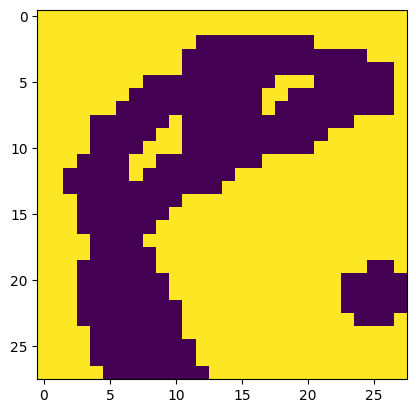

In [14]:
df = pd.read_csv('digits.csv')
img = df.iloc[3059, :].to_numpy()
img = img.reshape(28, 28)
plt.imshow(img)
print(len(df))